In [1]:
import sys, os
os.path.dirname(sys.executable)

'C:\\Users\\hjoon\\AppData\\Local\\Continuum\\anaconda3\\envs\\pytorch3d0'

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

print('python:', sys.version)
print('torch :', torch.__version__)
print('cuda  :', torch.version.cuda)
%load_ext autoreload
%autoreload 2

python: 3.8.2 (default, Apr 14 2020, 19:01:40) [MSC v.1916 64 bit (AMD64)]
torch : 1.4.0
cuda  : 10.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

The syntax of the command is incorrect.
--2020-04-15 19:43:18--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: 'data/cow_mesh/cow.obj.2'

     0K .......... .......... .......... .......... .......... 15%  798K 0s
    50K .......... .......... .......... .......... .......... 30% 26.3M 0s
   100K .......... .......... .......... .......... .......... 46% 1.16M 0s
   150K .......... .......... .......... .......... .......... 61% 23.7M 0s
   200K .......... .......... .......... .......... .......... 77% 2.02M 0s
   250K .......... .......... .......... .......... .......... 92% 28.0M 0s
   300K .......... .......... ..                              100% 53.3M=0.1s

2020-04-15 19:43:19 (2.34 MB/s) 

In [46]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
texture_image=mesh.textures.maps_padded()

<IPython.core.display.Javascript object>


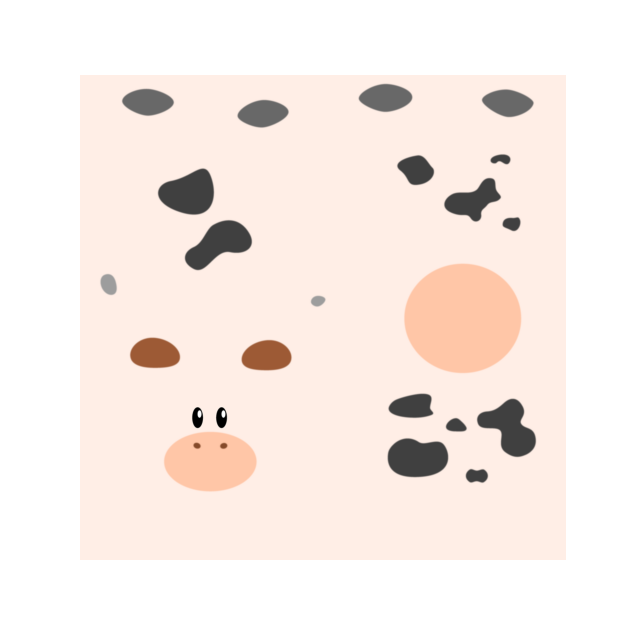

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

In [47]:
R, T = look_at_view_transform(2.7, 0, 10) 
fl = torch.from_numpy(np.array([12.0])).unsqueeze(0)
pp = torch.from_numpy(np.array([12.0, 12])).unsqueeze(0)
print(fl.shape)
print(pp.shape)
cameras_per = SfMPerspectiveCameras(device=device, R=R, T=T, focal_length=fl, principal_point=pp)
cameras_ort  = SfMOrthographicCameras(device=device, R=R, T=T, focal_length=fl, principal_point=pp)

Kper = cameras_per.get_projection_transform()
print(Kper.get_matrix())
Kort = cameras_ort.get_projection_transform()
print(Kort.get_matrix())

torch.Size([1, 1])
torch.Size([1, 2])
tensor([[[12.,  0.,  0.,  0.],
         [ 0., 12.,  0.,  0.],
         [12., 12.,  0.,  1.],
         [ 0.,  0.,  1.,  0.]]], device='cuda:0', dtype=torch.float64)
tensor([[[12.,  0.,  0.,  0.],
         [ 0., 12.,  0.,  0.],
         [ 0.,  0.,  1.,  0.],
         [12., 12.,  0.,  1.]]], device='cuda:0', dtype=torch.float64)


<IPython.core.display.Javascript object>


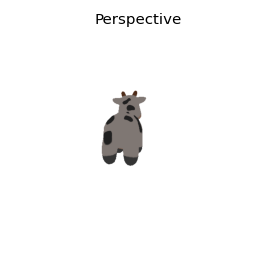

In [62]:
R, T = look_at_view_transform(2.7, 0, 10) 
fl = torch.from_numpy(np.array([1]).astype(np.float32)).unsqueeze(0)
pp = torch.from_numpy(np.array([0.1, 0.1]).astype(np.float32)).unsqueeze(0)
cameras  = SfMPerspectiveCameras(device=device, R=R, T=T, focal_length=fl, principal_point=pp)

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
images = renderer(mesh)

plt.figure(figsize=(3, 3))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.title('Perspective')
plt.grid("off");
plt.axis("off");
# # 3d view
# %matplotlib notebook
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# L = 1
# ax.plot([0, L], [0, 0], [0, 0], 'r')
# ax.plot([0, 0], [0, L], [0, 0], 'g')
# ax.plot([0, 0], [0, 0], [0, L], 'b')

# # camera 
# cam_pos = cameras.get_camera_center()
# cam_pos = cam_pos.squeeze().cpu().numpy()
# ax.scatter(cam_pos[0], cam_pos[1], cam_pos[2], s=100, c='r')
# E = cameras.get_world_to_view_transform().get_matrix()
# E = E.squeeze().cpu().numpy()
# Rext = E[0:3, 0:3]
# Xw = np.array([1, 0, 0])*L
# Yw = np.array([0, 1, 0])*L
# Zw = np.array([0, 0, 1])*L
# Rcam = Rext.T
# Xc_w = Xw.dot(Rcam)
# Yc_w = Yw.dot(Rcam)
# Zc_w = Zw.dot(Rcam)
# ax.plot([cam_pos[0], cam_pos[0] + Xc_w[0]], [cam_pos[1], cam_pos[1] + Xc_w[1]], [cam_pos[2], cam_pos[2] + Xc_w[2]], 'r')
# ax.plot([cam_pos[0], cam_pos[0] + Yc_w[0]], [cam_pos[1], cam_pos[1] + Yc_w[1]], [cam_pos[2], cam_pos[2] + Yc_w[2]], 'g')
# ax.plot([cam_pos[0], cam_pos[0] + Zc_w[0]], [cam_pos[1], cam_pos[1] + Zc_w[1]], [cam_pos[2], cam_pos[2] + Zc_w[2]], 'b')
# ax.set_xlim([-3, 3])
# ax.set_ylim([-3, 3])
# ax.set_zlim([-3, 3])
# # lookat
# print(R)
# print(Rext)
# # mesh
# vs = mesh.verts_packed().squeeze().cpu().numpy()
# ax.scatter(vs[:, 0], vs[:, 1], vs[:, 2])


<IPython.core.display.Javascript object>


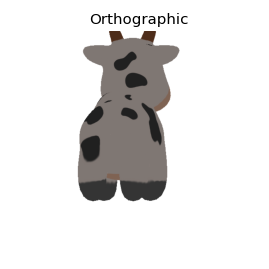

In [63]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 10) 
fl = torch.from_numpy(np.array([1]).astype(np.float32)).unsqueeze(0)
pp = torch.from_numpy(np.array([0.1, 0.1]).astype(np.float32)).unsqueeze(0)
cameras  = SfMOrthographicCameras(device=device, R=R, T=T, focal_length=fl, principal_point=pp)
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)

plt.figure(figsize=(3, 3))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.title('Orthographic')
plt.grid("off");
plt.axis("off");
           
# # 3d view
# %matplotlib notebook
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# L = 1
# ax.plot([0, L], [0, 0], [0, 0], 'r')
# ax.plot([0, 0], [0, L], [0, 0], 'g')
# ax.plot([0, 0], [0, 0], [0, L], 'b')

# # camera 
# cam_pos = cameras.get_camera_center()
# cam_pos = cam_pos.squeeze().cpu().numpy()
# ax.scatter(cam_pos[0], cam_pos[1], cam_pos[2], s=100, c='r')
# E = cameras.get_world_to_view_transform().get_matrix()
# E = E.squeeze().cpu().numpy()
# Rext = E[0:3, 0:3]
# Xw = np.array([1, 0, 0])*L
# Yw = np.array([0, 1, 0])*L
# Zw = np.array([0, 0, 1])*L
# Rcam = Rext.T
# Xc_w = Xw.dot(Rcam)
# Yc_w = Yw.dot(Rcam)
# Zc_w = Zw.dot(Rcam)
# ax.plot([cam_pos[0], cam_pos[0] + Xc_w[0]], [cam_pos[1], cam_pos[1] + Xc_w[1]], [cam_pos[2], cam_pos[2] + Xc_w[2]], 'r')
# ax.plot([cam_pos[0], cam_pos[0] + Yc_w[0]], [cam_pos[1], cam_pos[1] + Yc_w[1]], [cam_pos[2], cam_pos[2] + Yc_w[2]], 'g')
# ax.plot([cam_pos[0], cam_pos[0] + Zc_w[0]], [cam_pos[1], cam_pos[1] + Zc_w[1]], [cam_pos[2], cam_pos[2] + Zc_w[2]], 'b')
# ax.set_xlim([-3, 3])
# ax.set_ylim([-3, 3])
# ax.set_zlim([-3, 3])
# # lookat
# print(R)
# print(Rext)
# # mesh
# vs = mesh.verts_packed().squeeze().cpu().numpy()
# ax.scatter(vs[:, 0], vs[:, 1], vs[:, 2])
# plt.show()

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [ ]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");